In [50]:
import pandas as pd

In [51]:
df = pd.read_csv("ml_data.csv")
df.head()

,avg_bpm,rmssd,sdnn,gsr_avg,mean_absolute_derivative,std_gsr,stress
0,71.287129,0.046690,0.046231,9339.129032,8.688751,552.346095,0
1,88.757396,0.012000,0.008485,8033.696062,10.214207,438.878372,0
2,84.905660,0.061400,0.053454,8002.003634,7.397931,410.890078,0
3,84.905660,0.061400,0.053454,7980.096348,7.805495,386.542361,0
4,81.190798,0.063676,0.078017,7962.944878,5.007646,365.678889,0


In [52]:
import sklearn.model_selection as ms
X = df.loc[:, df.columns != "stress"]
X.head()

,avg_bpm,rmssd,sdnn,gsr_avg,mean_absolute_derivative,std_gsr
0,71.287129,0.046690,0.046231,9339.129032,8.688751,552.346095
1,88.757396,0.012000,0.008485,8033.696062,10.214207,438.878372
2,84.905660,0.061400,0.053454,8002.003634,7.397931,410.890078
3,84.905660,0.061400,0.053454,7980.096348,7.805495,386.542361
4,81.190798,0.063676,0.078017,7962.944878,5.007646,365.678889


In [53]:
Y = df.loc[:, df.columns == "stress"]
Y.head()

,stress
0,0
1,0
2,0
3,0
4,0


In [54]:
from sklearn.model_selection import train_test_split

# split it so that the first recording is training dataset, and 2nd recording is testing dataset
# data comes like this, all calm recordings 1 and 2, then all stress recordings 1 and 2
# We want all calm recordings 1 and all stress recordings 1 in X_train
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle

print(Counter(Y["stress"]))

calm_recording_1_length = int(1168/4)
calm_recording_2_length = int(1200/4)
stress_recording_1_length = int(1284/4)
stress_recording_2_length = int(1520/4)

# Define slice indices
calm1_start = 0
calm1_end = calm1_start + calm_recording_1_length

calm2_start = calm1_end
calm2_end = calm2_start + calm_recording_2_length

stress1_start = calm2_end
stress1_end = stress1_start + stress_recording_1_length

stress2_start = stress1_end
stress2_end = stress2_start + stress_recording_2_length

# Stack properly using concat (NOT +)
X_train = pd.concat([
    X.iloc[calm1_start:calm1_end, :],
    X.iloc[stress1_start:stress1_end, :]
])

X_test = pd.concat([
    X.iloc[calm2_start:calm2_end, :],
    X.iloc[stress2_start:stress2_end, :]
])

# Do the same for Y
Y_train = pd.concat([
    Y.iloc[calm1_start:calm1_end],
    Y.iloc[stress1_start:stress1_end]
])

Y_test = pd.concat([
    Y.iloc[calm2_start:calm2_end],
    Y.iloc[stress2_start:stress2_end]
])

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

Counter({1: 699, 0: 590})
(613, 6) (676, 6)
(613, 1) (676, 1)


In [55]:
X_train.head()

,avg_bpm,rmssd,sdnn,gsr_avg,mean_absolute_derivative,std_gsr
670,77.888360,0.098752,0.119164,3359.891429,1.531244,348.858120
101,69.870845,0.088546,0.113002,4828.571973,2.764526,824.900122
131,66.683132,0.146319,0.149301,6124.757865,2.462128,396.242347
693,85.376532,0.048758,0.053750,2257.462345,1.308668,381.997600
909,72.727273,0.106623,0.103216,754.154143,2.022058,433.567687


In [56]:
Y_train.head()

,stress
670,1
101,0
131,0
693,1
909,1


In [57]:
from sklearn.svm import SVC
model = SVC()
model

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [58]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, np.ravel(Y_train))

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [59]:
model.score(X_test_scaled, Y_test)

0.8683431952662722

In [60]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test_scaled)
print(classification_report(Y_test, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       298
           1       1.00      0.76      0.87       378

    accuracy                           0.87       676
   macro avg       0.89      0.88      0.87       676
weighted avg       0.90      0.87      0.87       676



In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = {'svm__C': [0.1, 1, 10, 100, 1000],
			'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale'],
			'svm__kernel': ['rbf']}
grid = GridSearchCV(pipeline, param_grid, refit=True, verbose=3)

In [62]:
grid.fit(X_train, np.ravel(Y_train))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/5] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 5/5] END svm__C=0.1, svm__gamma=1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 5/5] END svm__C=0.1, svm__gamma=0.1, svm__kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END svm__C=0.1, svm__gamma=0.01, svm__k

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...svm', SVC())])"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'svm__C': [0.1, 1, ...], 'svm__gamma': [1, 0.1, ...], 'svm__kernel': ['rbf']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the sco

In [63]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=0.1, gamma=1))])
1.0


In [64]:
grid_predictions = grid.predict(X_test)
print(grid.score(X_test, Y_test))
print(classification_report(Y_test, grid_predictions, zero_division=0))

0.7085798816568047
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       298
           1       1.00      0.48      0.65       378

    accuracy                           0.71       676
   macro avg       0.80      0.74      0.70       676
weighted avg       0.82      0.71      0.69       676



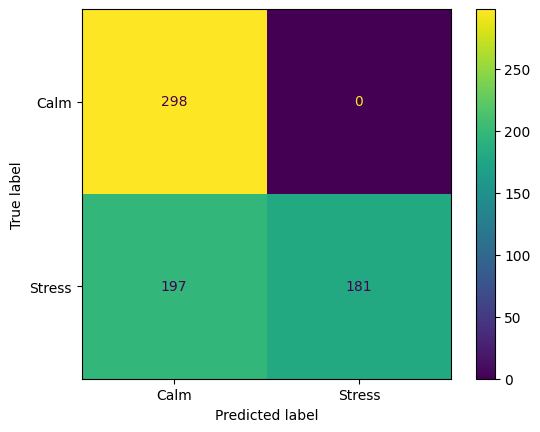

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, grid_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Calm", "Stress"])
disp.plot()
plt.show()

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [67]:
param_grid_rf = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', n_jobs=-1, verbose=3)
grid_rf.fit(X_train, np.ravel(Y_train))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 3/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=1.000 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=1.000 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=1.000 total time=   0.1s
[CV 4/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=1.000 total time=   0.2s
[CV 1/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=1.000 total time=   0.2s
[CV 1/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=200;, score=1.000 total time=   0.3s
[CV 2/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=200;, score=1.000 total time=   0.3s
[CV 4/5] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=200;, score=1.000 total time=   0.3s
[CV 3/5] END max_depth=3, max_fe

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [3, 5, ...], 'max_features': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [100, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter ca

In [68]:
grid_rf.score(X_test, Y_test)

0.9838709677419355

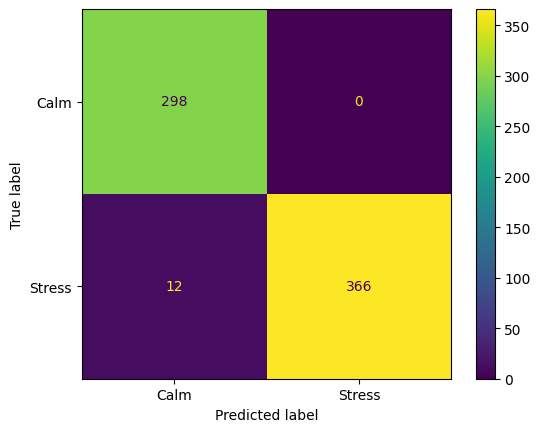

In [69]:
cm_rf = confusion_matrix(Y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(cm_rf, display_labels=["Calm", "Stress"])
disp.plot()
plt.show()

# Results
Random Forest Classifier has a far better score at 98% compared to Support Vector Machine's 71%.
Therefore we will use a Random Forest Classifier over the Support Vector Machine for this dataset, due to the improved performance.